## Get Data Loader for Test Dataset  

In [1]:
import sys
sys.path.append('C:/Users/Da/Desktop/image-caption/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# Define a transform to the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

True
True
Vocabulary successfully loaded from vocab.pkl file!


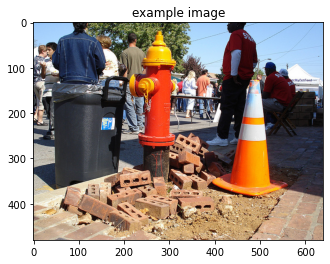

In [2]:
#plot sample image for test data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

## Load Trained Models  

In [3]:
#cheak GPU
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
import os
import torch
from model import EncoderCNN, DecoderRNN
%load_ext autoreload
%autoreload 2
# Specify the saved models to load.
encoder_file = 'encoder-10.pkl' 
decoder_file = 'decoder-10.pkl'

embed_size = 256
hidden_size = 512
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to evaluate mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DecoderRNN(
  (word_embedding): Embedding(9947, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=9947, bias=True)
)

In [10]:
# Move image Pytorch Tensor to GPU
image = image.to(device)

# Get the embedded image features through the model to get a predicted caption.
features = encoder(image).unsqueeze(1)
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 165, 166, 21, 3, 2948, 2035, 161, 46, 408, 185, 18]


In [11]:
def clean_sentence(output):
    cleaned_list = []
    for index in output:
        if  (index == 1) :
            continue
        cleaned_list.append(data_loader.dataset.vocab.idx2word[index])
    cleaned_list = cleaned_list[1:-1] # Discard <start> and <end> 

    sentence = ' '.join(cleaned_list) # Convert list of string to                                                    
    sentence = sentence.capitalize()    
    return sentence


In [12]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: A fire hydrant with a hose connected to it 's side


## Get predict sentence  

In [13]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

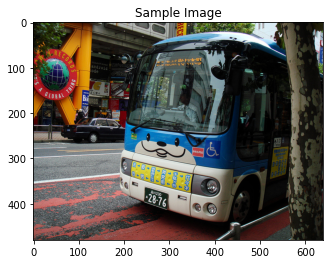

A double decker bus is parked in front of a building


In [14]:
get_prediction()

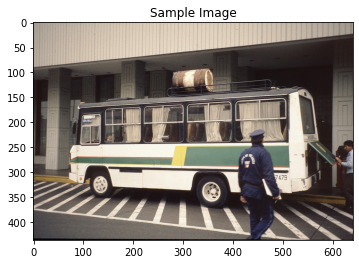

A man standing next to a train on a train track


In [16]:
get_prediction()

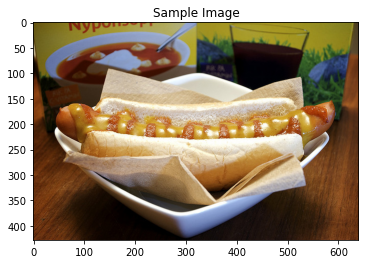

A hot dog with relish and mustard on a plate


In [20]:
get_prediction()